In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
cleaned = pd.read_csv("processed_afl_dataset.csv")
cleaned.drop(['Unnamed: 0','GM'], axis=1, inplace=True)

# Mutual Information

## Discretization (Binning)

In [3]:
c = cleaned[['HB','DI','IF','CL','CP','BR']]

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
# Create a DataFrame that contains the target variable and the characteristic variables
df = pd.DataFrame({'HB': c['HB'], 'DI': c['DI'], 'IF': c['IF'], 'CL': c['CL'], 'CP': c['CP'], 'BR': c['BR']})

# Discretize the continuous variable BR into 2 bins
n_bins = 2
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
df['BR_binned'] = est.fit_transform(df[['BR']])
print(df.head(10))

# Claculate the correlation
corr_matrix = df[['HB', 'DI', 'IF', 'CL', 'CP', 'BR_binned']].corr()
# correlation matrix
print(corr_matrix)

          HB         DI        IF        CL         CP        BR  BR_binned
0  17.782609  32.739130  5.391304  8.652174  17.782609  1.086957        1.0
1  16.120000  29.960000  4.400000  7.640000  16.000000  1.120000        1.0
2  15.782609  30.652174  5.260870  6.391304  11.608696  0.478261        0.0
3  14.583333  29.333333  4.333333  3.875000   9.041667  1.041667        1.0
4  13.166667  28.041667  6.500000  4.625000  12.708333  1.000000        1.0
5  18.750000  32.950000  4.650000  7.500000  15.000000  0.500000        0.0
6  11.320000  25.760000  2.760000  1.600000   6.360000  0.440000        0.0
7  15.416667  26.791667  3.791667  5.708333  11.958333  0.458333        0.0
8  17.800000  32.100000  4.650000  4.400000  11.450000  0.700000        1.0
9  11.500000  28.454545  5.545455  7.909091  15.181818  1.227273        1.0
                 HB        DI        IF        CL        CP  BR_binned
HB         1.000000  0.859024  0.656623  0.783693  0.826426   0.313548
DI         0.859024  1

# KNN classifier

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['HB', 'DI','IF', 'CL', 'CP']], df['BR_binned'], test_size=0.3, random_state=42)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# Normalize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create knn with k=3
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# Model Evaluation

In [7]:
from sklearn.metrics import accuracy_score
# Prediction
y_pred = knn.predict(X_test)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9951456310679612


# Confusion Matrix

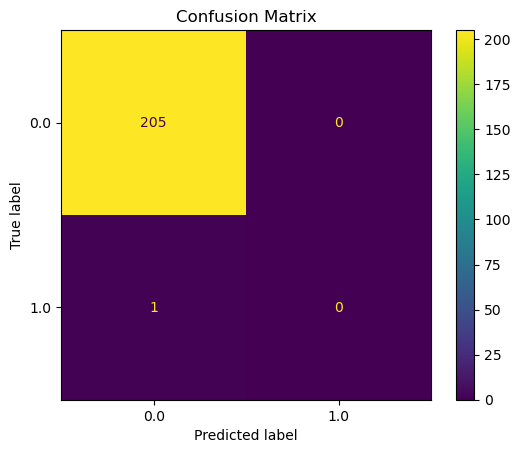

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion matrix (variable name)
cm = confusion_matrix(y_test, # test data
                      y_pred, # predictions
                      labels = knn.classes_) # class labels from the knn model

disp = ConfusionMatrixDisplay(confusion_matrix = cm, # pass through the created confusion matrix
                              display_labels = knn.classes_) # class labels from the knn model

disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Bootstrapping (imbalanced data)

In [9]:
# scikit-learn bootstrap
from sklearn.utils import resample
from sklearn.metrics import recall_score, precision_score, f1_score
X = np.array(df[['HB', 'DI','IF', 'CL', 'CP']])
y = np.array(df['BR_binned'])
n = X.shape[0]
dataidx = range(n)
k = 500

# Storing the metrics for each dataset
accuracies = []
precisions = []
recalls = []

# Loop through each dataset, split data based on bootstrapping indices + fit model + evaluate
for i in range(k):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=i)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_train_1 = X[boot_index,:]
    X_test_1 = X[oob_index,:]
    y_train_1 = y[boot_index]
    y_test_1 = y[oob_index]

    # Normalize the data
    scaler = StandardScaler().fit(X_train_1)
    X_train_1 = scaler.transform(X_train_1)
    X_test_1 = scaler.transform(X_test_1)

    # Train
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_1, y_train_1)
    
    # Predict
    y_pred_1 = knn.predict(X_test_1)
    
    # Evaluate
    accuracies.append(accuracy_score(y_test_1, y_pred_1))
    precisions.append(precision_score(y_test_1, y_pred_1))
    recalls.append(recall_score(y_test_1, y_pred_1))

print("Accuracy from each bootstrap sample:", accuracies)
#Display average of accuracy scores
avg_acc_score = np.mean(accuracies)
print("Mean accuracy from all bootstrap samples:", avg_acc_score)

/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Accuracy from each bootstrap sample: [0.9658119658119658, 0.9713114754098361, 0.9793388429752066, 0.9682539682539683, 0.9713114754098361, 0.9752066115702479, 0.9647058823529412, 0.9518072289156626, 0.9806201550387597, 0.9806949806949807, 0.968503937007874, 0.9681274900398407, 0.9591836734693877, 0.9884615384615385, 0.963265306122449, 0.9656652360515021, 0.9642857142857143, 0.975609756097561, 0.9607843137254902, 0.9915254237288136, 0.968503937007874, 0.9681274900398407, 0.9644268774703557, 0.9571984435797666, 0.9961538461538462, 0.9693486590038314, 0.972, 0.9838709677419355, 0.967391304347826, 0.983739837398374, 0.9793388429752066, 0.9838056680161943, 0.9839357429718876, 0.9641434262948207, 0.97165991902834, 0.9921568627450981, 0.9688715953307393, 0.9717741935483871, 0.9762845849802372, 0.9839357429718876, 0.9678714859437751, 0.9918032786885246, 0.981203007518797, 0.9839357429718876, 0.9832635983263598, 0.9641434262948207, 0.9766536964980544, 0.9918032786885246, 0.9757085020242915, 0.97

In [10]:
print("Precision from each bootstrap sample:", precisions)
#Display average of precision scores
avg_precision_score = np.mean(precisions)
print("Mean precision from all bootstrap samples:", avg_precision_score)


Precision from each bootstrap sample: [0.3333333333333333, 0.25, 0.0, 0.16666666666666666, 0.0, 0.0, 0.2, 0.1111111111111111, 0.5, 1.0, 0.14285714285714285, 0.0, 0.2, 0.75, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 1.0, 0.0, 0.25, 0.2857142857142857, 0.0, 0.75, 0.0, 0.0, 0.25, 0.0, 0.3333333333333333, 0.4, 1.0, 0.5, 0.0, 0.0, 1.0, 0.0, 0.6, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.5, 0.6, 1.0, 1.0, 0.4, 1.0, 0.2, 0.0, 0.2857142857142857, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.25, 0.0, 0.0, 0.6666666666666666, 0.5, 0.14285714285714285, 0.5, 0.4, 0.0, 0.3333333333333333, 0.5, 0.0, 0.5, 0.3333333333333333, 0.0, 0.0, 0.5, 0.2222222222222222, 0.25, 0.0, 1.0, 0.1, 0.6666666666666666, 1.0, 0.0, 0.5, 0.2, 0.2857142857142857, 0.6666666666666666, 0.5, 1.0, 0.5, 0.0, 0.0, 0.14285714285714285, 0.75, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.6666666666666666, 0.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.0, 0.4, 0.25, 0.2, 0.4, 0.2857142857142857, 0.5, 0.5, 1.0, 0.25, 0.0, 0.5, 0.3333333333333333, 0.5, 0.0, 0.2, 0.0, 0.2, 0.0, 0

In [11]:
print("Recall from each bootstrap sample:", recalls)
#Display average of recall scores
avg_recall_score = np.mean(recalls)
print("Mean recall from all bootstrap samples:", avg_recall_score)

Recall from each bootstrap sample: [0.14285714285714285, 0.2, 0.0, 0.25, 0.0, 0.0, 0.16666666666666666, 0.2, 0.2, 0.2857142857142857, 0.3333333333333333, 0.0, 0.14285714285714285, 0.6, 0.0, 0.25, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.16666666666666666, 0.3333333333333333, 0.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.3333333333333333, 0.5, 0.2, 0.5, 0.0, 0.0, 0.3333333333333333, 0.0, 0.375, 0.14285714285714285, 0.3333333333333333, 0.25, 0.5, 0.0, 0.0, 0.5, 0.3, 0.14285714285714285, 0.3333333333333333, 0.4, 0.375, 0.25, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.16666666666666666, 0.3333333333333333, 0.16666666666666666, 0.0, 0.0, 0.4, 0.1111111111111111, 0.2, 0.25, 0.4, 0.0, 0.3333333333333333, 0.14285714285714285, 0.0, 0.1, 0.14285714285714285, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 0.2, 0.0, 0.16666666666666666, 0.25, 0.2222222222222222, 0.4, 0.0, 0.4, 0.2, 0.4, 0.4, 0.3333333333333333, 0.2222222222222222, 0.2, 0.0, 0.0, 0.5, 0.42857142857142855, 0.333333333333333